# NN by Numpy

In [11]:
import skimage.data
import numpy
import matplotlib
import sys
%matplotlib inline

In [12]:
#一、读取输入图像:从skimage Python库中读取已经存在的图像，并将其转换为灰度图
img = skimage.data.chelsea()

img = skimage.color.rgb2gray(img)

In [13]:
#二、准备滤波器：第一个卷积层Conv准备滤波器组（Layer 1，缩写为l1）
l1_filter = numpy.zeros((2,3,3))

根据滤波器的数目和每个滤波器的大小来创建零数组。上述代码创建了2个3x3大小的滤波器，（2,3,3）中的元素数字分别表示2：滤波器的数目（num_filters）、3：表示滤波器的列数、3：表示滤波器的行数。由于输入图像是灰度图，读取后变成2维图像矩阵，因此滤波器的尺寸选择为2维阵列，舍去了深度。如果图像是彩色图（具有3个通道，分别为RGB），则滤波器的大小必须为（3,3,3），最后一个3表示深度，上述代码也要更改，变成（2,3,3,3）。滤波器组的大小由自己指定，但没有给定滤波器中具体的数值，一般采用随机初始化。下列一组值可以用来检查垂直和水平边缘：

In [14]:
#
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = numpy.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])


In [15]:
def conv(img, conv_filter):
    #conv函数只接受两个参数，分别为输入图像、滤波器组：
    #该函数首先确保每个滤波器的深度等于图像通道的数目，代码如下。if语句首先检查图像与滤波器是否有一个深度通道，若存在，则检查其通道数是否相等，如果匹配不成功，则报错。
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: 
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    #此外，滤波器的大小应该是奇数，且每个滤波器的大小是相等的。这是根据下面两个if条件语块来检查的。如果条件不满足，则程序报错并退出。
    if conv_filter.shape[1] != conv_filter.shape[2]: 
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: 
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()
    #上述条件都满足后，通过初始化一个数组来作为滤波器的值，通过下面代码来指定滤波器的值
    #由于没有设置步幅（stride）或填充（padding），默认为步幅设置为1，无填充。那么卷积操作后得到的特征图大小为（img_rows-filter_rows+1, image_columns-filter_columns+1, num_filters），即输入图像的尺寸减去滤波器的尺寸后再加1。每个滤波器都会输出一个特征图。
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))
    
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        #循环遍历滤波器组中的每个滤波器后，通过下面代码更新滤波器的状态
        curr_filter = conv_filter[filter_num, :] 
        #如果输入图像不止一个通道，则滤波器必须具有同样的通道数目。只有这样，卷积过程才能正常进行。最后将每个滤波器的输出求和作为输出特征图。下面的代码检测输入图像的通道数，如果图像只有一个通道，那么一次卷积即可完成整个过程
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) 
            for ch_num in range(1, curr_filter.shape[-1]): 
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: 
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map 
    return feature_maps 

上述代码中conv_函数与之前的conv函数不同，函数conv只接受输入图像和滤波器组这两个参数，本身并不进行卷积操作，它只是设置用于conv_函数执行卷积操作的每一组输入滤波器。下面是conv_函数的实现代码：

In [16]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[0]
    result = numpy.zeros((img.shape))
    
    for r in numpy.uint16(numpy.arange(filter_size/2, 
                          img.shape[0]-filter_size/2-2)):
        for c in numpy.uint16(numpy.arange(filter_size/2, img.shape[1]-filter_size/2-2)):
            #每个滤波器在图像上迭代卷积的尺寸相同，通过以下代码实现
            curr_region = img[r:r+filter_size, c:c+filter_size]
            #在图像区域矩阵和滤波器之间对位相乘，并将结果求和以得到单值输出：
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result) 
            result[r, c] = conv_sum 
            
    final_result = result[numpy.uint16(filter_size/2):result.shape[0]-numpy.uint16(filter_size/2), 
                          numpy.uint16(filter_size/2):result.shape[1]-numpy.uint16(filter_size/2)]
    return final_result

In [17]:
#三、卷积层（Conv Layer）：构建好滤波器后，接下来就是与输入图像进行卷积操作。下面代码使用conv函数将输入图像与滤波器组进行卷积
l1_feature_map = conv(img, l1_filter)

Filter  1
Filter  2


输入图像与每个滤波器卷积后，通过conv函数返回特征图。下图显示conv层返回的特征图（由于l1卷积层的滤波器参数为（2,3,3），即2个3x3大小的卷积核，最终输出2个特征图）

In [18]:
#ReLU激活函数（ReLU）：
def relu(feature_map):
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0,feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max(feature_map[r, c, map_num], 0)
    return relu_out

In [19]:
#四、ReLU激活函数层：ReLU层将ReLU激活函数应用于conv层输出的每个特征图上
l1_feature_map_relu = relu(l1_feature_map)

In [20]:
#五 、最大池化层：
def pooling(feature_map, size=2, stride=2):
    #该函数接受3个参数，分别为ReLU层的输出，滤波器的大小和步幅。首先也是创建一个空数组，用来保存该函数的输出。数组大小根据输入特征图的尺寸、滤波器大小以及步幅来确定
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride),
                            numpy.uint16((feature_map.shape[1]-size+1)/stride),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0,feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1]-size-1, stride):
                pool_out[r2, c2, map_num] = numpy.max(feature_map[r:r+size,  c:c+size])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

In [21]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

In [22]:
#六、多个层堆叠
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])

l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)

l2_feature_map_relu = relu(l2_feature_map)

l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)

Filter  1
Filter  2
Filter  3


In [23]:
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])

l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)

l3_feature_map_relu = relu(l3_feature_map)

l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)

Filter  1


<function matplotlib.pyplot.show>

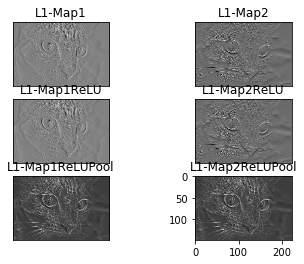

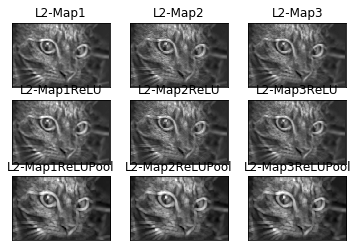

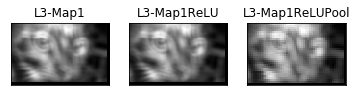

In [26]:
#七.可视化
fig1, ax1 = matplotlib.pyplot.subplots(nrows=3, ncols=2)
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")




fig2, ax2 = matplotlib.pyplot.subplots(nrows=3, ncols=3)
ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")



fig3, ax3 = matplotlib.pyplot.subplots(nrows=1, ncols=3)
ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")

matplotlib.pyplot.show
